In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

from ydata_profiling import ProfileReport

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import mlflow
from mlflow.models import infer_signature

## 1. Data Loading

The dataset is loaded from a CSV file. It's important to specify the separator, which is a comma (`,`) in this case, as some files use a semicolon (`;`).

In [9]:
Garment_worker = pd.read_csv('Dataset/garments_worker_productivity.csv', sep=',')
Garment_worker.head()

date   quarter  department       day  team  targeted_productivity  \
0  1/1/2015  Quarter1      sweing  Thursday     8                   0.80   
1  1/1/2015  Quarter1  finishing   Thursday     1                   0.75   
2  1/1/2015  Quarter1      sweing  Thursday    11                   0.80   
3  1/1/2015  Quarter1      sweing  Thursday    12                   0.80   
4  1/1/2015  Quarter1      sweing  Thursday     6                   0.80   

     smv     wip  over_time  incentive  idle_time  idle_men  \
0  26.16  1108.0       7080         98        0.0         0   
1   3.94     NaN        960          0        0.0         0   
2  11.41   968.0       3660         50        0.0         0   
3  11.41   968.0       3660         50        0.0         0   
4  25.90  1170.0       1920         50        0.0         0   

   no_of_style_change  no_of_workers  actual_productivity  
0                   0           59.0             0.940725  
1                   0            8.0             0.886500  
2                   0           30.5             0.800570  
3                   0           30.5             0.800570  
4                   0           56.0             0.800382

A copy of the original dataset is created to serve as a backup in case of any erroneous modifications.

In [10]:
data = Garment_worker.copy()

In [11]:
# Garment_worker = data.copy()

### Initial Data Inspection
Let's get a first look at the dataset's structure, data types, and summary statistics.

In [12]:
Garment_worker.info() # Display dataset information (observations, variables, data types, etc.)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

In [13]:
Garment_worker.describe()

team  targeted_productivity          smv           wip  \
count  1197.000000            1197.000000  1197.000000    691.000000   
mean      6.426901               0.729632    15.062172   1190.465991   
std       3.463963               0.097891    10.943219   1837.455001   
min       1.000000               0.070000     2.900000      7.000000   
25%       3.000000               0.700000     3.940000    774.500000   
50%       6.000000               0.750000    15.260000   1039.000000   
75%       9.000000               0.800000    24.260000   1252.500000   
max      12.000000               0.800000    54.560000  23122.000000   

          over_time    incentive    idle_time     idle_men  \
count   1197.000000  1197.000000  1197.000000  1197.000000   
mean    4567.460317    38.210526     0.730159     0.369256   
std     3348.823563   160.182643    12.709757     3.268987   
min        0.000000     0.000000     0.000000     0.000000   
25%     1440.000000     0.000000     0.000000     0.000000   
50%     3960.000000     0.000000     0.000000     0.000000   
75%     6960.000000    50.000000     0.000000     0.000000   
max    25920.000000  3600.000000   300.000000    45.000000   

       no_of_style_change  no_of_workers  actual_productivity  
count         1197.000000    1197.000000          1197.000000  
mean             0.150376      34.609858             0.735091  
std              0.427848      22.197687             0.174488  
min              0.000000       2.000000             0.233705  
25%              0.000000       9.000000             0.650307  
50%              0.000000      34.000000             0.773333  
75%              0.000000      57.000000             0.850253  
max              2.000000      89.000000             1.120437

### Initial Exploratory Analysis
For a quick initial analysis, a `ProfileReport` is used to observe various statistical values, trends, alerts, correlations, etc.

In [4]:
profile = ProfileReport(Garment_worker, title="Garment Worker Report", explorative=True) # Generate a report
profile.to_file("Garment_Worker_report.html") # Save the report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:00<00:00, 74.27it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

**Observations from the Profile Report:**
The report reveals that the `wip` variable has missing values, others have many zeros, and some variables show significant skewness, among other factors to consider. Later, we will decide how to handle these irregularities.

In [8]:
profile.to_notebook_iframe() # Display the report in the notebook

## 2. Data Preparation

### Remove Unnecessary Columns

This decision is based on the project's objective. The question is: Which variables are NOT necessary to perform the desired task?

Predicting employee performance is challenging because human behavior can be volatile. Certain stimuli can cause significant changes in behavior, mood, concentration, etc., which can alter performance. However, some variables represent highly specific information that may not be very relevant for the task. Therefore, the following variables will be removed: `quarter`, `team`, `idle_time`, `idle_men`, `no_of_style_change`.

- The `quarter` variable will be removed because it is not very useful for the prediction task. Although it could relate performance to "the part of the month," this information can be extracted and explained by the `Date` variable, which includes the days of the month.

- The `team` variable will be removed because it is an identifier for each team. This is considered a variable that can introduce a lot of bias. To determine productivity, the team's label is not as important as its members, who can change over time. The model could incorrectly associate a certain team label with higher or lower productivity, which is not accurate.

- The `idle_time` and `idle_men` variables will be removed because the information they provide is not very relevant. It is expected that if an interruption occurs in the process, productivity will be negatively affected. Moreover, interruptions are often unexpected, so this is not data that can be premeditated for inclusion in a prediction task.

- The `no_of_style_change` variable will be removed as it is considered too specific and not very relevant for the prediction task.

In [14]:
Garment_worker.drop(['quarter', 'team', 'idle_time', 'idle_men', 'no_of_style_change'], axis=1, inplace=True) # Remove several columns

In [15]:
Garment_worker.head()

date  department       day  targeted_productivity    smv     wip  \
0  1/1/2015      sweing  Thursday                   0.80  26.16  1108.0   
1  1/1/2015  finishing   Thursday                   0.75   3.94     NaN   
2  1/1/2015      sweing  Thursday                   0.80  11.41   968.0   
3  1/1/2015      sweing  Thursday                   0.80  11.41   968.0   
4  1/1/2015      sweing  Thursday                   0.80  25.90  1170.0   

   over_time  incentive  no_of_workers  actual_productivity  
0       7080         98           59.0             0.940725  
1        960          0            8.0             0.886500  
2       3660         50           30.5             0.800570  
3       3660         50           30.5             0.800570  
4       1920         50           56.0             0.800382

In [16]:
Garment_worker.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   department             1197 non-null   object 
 2   day                    1197 non-null   object 
 3   targeted_productivity  1197 non-null   float64
 4   smv                    1197 non-null   float64
 5   wip                    691 non-null    float64
 6   over_time              1197 non-null   int64  
 7   incentive              1197 non-null   int64  
 8   no_of_workers          1197 non-null   float64
 9   actual_productivity    1197 non-null   float64
dtypes: float64(5), int64(2), object(3)
memory usage: 93.6+ KB


In [17]:
Garment_worker.describe()

targeted_productivity          smv           wip     over_time  \
count            1197.000000  1197.000000    691.000000   1197.000000   
mean                0.729632    15.062172   1190.465991   4567.460317   
std                 0.097891    10.943219   1837.455001   3348.823563   
min                 0.070000     2.900000      7.000000      0.000000   
25%                 0.700000     3.940000    774.500000   1440.000000   
50%                 0.750000    15.260000   1039.000000   3960.000000   
75%                 0.800000    24.260000   1252.500000   6960.000000   
max                 0.800000    54.560000  23122.000000  25920.000000   

         incentive  no_of_workers  actual_productivity  
count  1197.000000    1197.000000          1197.000000  
mean     38.210526      34.609858             0.735091  
std     160.182643      22.197687             0.174488  
min       0.000000       2.000000             0.233705  
25%       0.000000       9.000000             0.650307  
50%       0.000000      34.000000             0.773333  
75%      50.000000      57.000000             0.850253  
max    3600.000000      89.000000             1.120437

### Remove Duplicates

Duplicates may or may not be removed, depending on the type of problem being addressed. For this dataset, there should be no duplicate values, as the many variables make it unlikely. A duplicate value would mean that a series of conditions and even the performance were exactly the same on two or more occasions, which is highly improbable (if not impossible). Additionally, the dataset has a date variable, which would mean that the conditions were repeated on the same day, making it even more unlikely.

In [18]:
Garment_worker.duplicated().sum() # Count duplicates in the dataset

9

In [19]:
Garment_worker.drop_duplicates(inplace=True) # Remove duplicates

In [20]:
Garment_worker.info() # Check the information again to see the count after removing duplicates

<class 'pandas.core.frame.DataFrame'>
Index: 1188 entries, 0 to 1196
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1188 non-null   object 
 1   department             1188 non-null   object 
 2   day                    1188 non-null   object 
 3   targeted_productivity  1188 non-null   float64
 4   smv                    1188 non-null   float64
 5   wip                    690 non-null    float64
 6   over_time              1188 non-null   int64  
 7   incentive              1188 non-null   int64  
 8   no_of_workers          1188 non-null   float64
 9   actual_productivity    1188 non-null   float64
dtypes: float64(5), int64(2), object(3)
memory usage: 102.1+ KB


In [21]:
Garment_worker.describe()

targeted_productivity          smv           wip     over_time  \
count            1188.000000  1188.000000    690.000000   1188.000000   
mean                0.729478    15.141019   1190.788406   4578.274411   
std                 0.098159    10.944883   1838.768379   3338.107020   
min                 0.070000     2.900000      7.000000      0.000000   
25%                 0.700000     3.940000    773.750000   1440.000000   
50%                 0.750000    15.260000   1039.500000   4080.000000   
75%                 0.800000    24.260000   1253.250000   6960.000000   
max                 0.800000    54.560000  23122.000000  25920.000000   

         incentive  no_of_workers  actual_productivity  
count  1188.000000    1188.000000          1188.000000  
mean     38.457912      34.774832             0.735029  
std     160.757602      22.188981             0.174369  
min       0.000000       2.000000             0.233705  
25%       0.000000       9.000000             0.650382  
50%       0.000000      34.000000             0.772458  
75%      50.000000      57.000000             0.850231  
max    3600.000000      89.000000             1.120437

### Remove Rows with Missing Values

Looking at the data information, we can see that the only variable with missing values is `wip`. Since this does not correspond to values with any specific trend (it represents the number of unfinished items, which can vary unpredictably), it is not possible to perform any type of data imputation. Therefore, the options are:

- Remove all rows where there are missing values.
- Completely remove the column where the missing values are present.

In this case, the second option was chosen because the amount of missing data represents almost 50% of the total observations, so the reduction in information would be quite large. Additionally, although the feature is considered relevant for the analysis, it is not entirely essential. Therefore, the decision was made to remove the `wip` column.

In [22]:
Garment_worker.drop(['wip'], axis=1, inplace=True)

In [23]:
Garment_worker.head()

date  department       day  targeted_productivity    smv  over_time  \
0  1/1/2015      sweing  Thursday                   0.80  26.16       7080   
1  1/1/2015  finishing   Thursday                   0.75   3.94        960   
2  1/1/2015      sweing  Thursday                   0.80  11.41       3660   
4  1/1/2015      sweing  Thursday                   0.80  25.90       1920   
5  1/1/2015      sweing  Thursday                   0.80  25.90       6720   

   incentive  no_of_workers  actual_productivity  
0         98           59.0             0.940725  
1          0            8.0             0.886500  
2         50           30.5             0.800570  
4         50           56.0             0.800382  
5         38           56.0             0.800125

In [24]:
Garment_worker.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1188 entries, 0 to 1196
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1188 non-null   object 
 1   department             1188 non-null   object 
 2   day                    1188 non-null   object 
 3   targeted_productivity  1188 non-null   float64
 4   smv                    1188 non-null   float64
 5   over_time              1188 non-null   int64  
 6   incentive              1188 non-null   int64  
 7   no_of_workers          1188 non-null   float64
 8   actual_productivity    1188 non-null   float64
dtypes: float64(4), int64(2), object(3)
memory usage: 92.8+ KB


In [25]:
Garment_worker.describe()

targeted_productivity          smv     over_time    incentive  \
count            1188.000000  1188.000000   1188.000000  1188.000000   
mean                0.729478    15.141019   4578.274411    38.457912   
std                 0.098159    10.944883   3338.107020   160.757602   
min                 0.070000     2.900000      0.000000     0.000000   
25%                 0.700000     3.940000   1440.000000     0.000000   
50%                 0.750000    15.260000   4080.000000     0.000000   
75%                 0.800000    24.260000   6960.000000    50.000000   
max                 0.800000    54.560000  25920.000000  3600.000000   

       no_of_workers  actual_productivity  
count    1188.000000          1188.000000  
mean       34.774832             0.735029  
std        22.188981             0.174369  
min         2.000000             0.233705  
25%         9.000000             0.650382  
50%        34.000000             0.772458  
75%        57.000000             0.850231  
max        89.000000             1.120437

### Analysis of Outliers and Invalid Data

Just as a dataset can have duplicate or missing data, it is also possible to have data that is out of the ordinary (outliers) for certain variables or even data that takes values that, depending on the type of variable analyzed in a given context, should not be possible (invalid). To address this, a review is conducted based on certain criteria to establish a threshold where such data can be considered outliers and/or invalid.

A `.describe()` is performed to observe the statistical information of each variable. This allows us to know the range of values it handles, the minimum, maximum, average value, etc.

In [26]:
Garment_worker.describe()

targeted_productivity          smv     over_time    incentive  \
count            1188.000000  1188.000000   1188.000000  1188.000000   
mean                0.729478    15.141019   4578.274411    38.457912   
std                 0.098159    10.944883   3338.107020   160.757602   
min                 0.070000     2.900000      0.000000     0.000000   
25%                 0.700000     3.940000   1440.000000     0.000000   
50%                 0.750000    15.260000   4080.000000     0.000000   
75%                 0.800000    24.260000   6960.000000    50.000000   
max                 0.800000    54.560000  25920.000000  3600.000000   

       no_of_workers  actual_productivity  
count    1188.000000          1188.000000  
mean       34.774832             0.735029  
std        22.188981             0.174369  
min         2.000000             0.233705  
25%         9.000000             0.650382  
50%        34.000000             0.772458  
75%        57.000000             0.850231  
max        89.000000             1.120437

At first glance, the data description looks quite normal and acceptable. There are no negative data in variables where there should not be, and the maximum values do not deviate (by much) from the scale of their average values. However, in the `actual_productivity` variable, there is a maximum value of 1.12, which should not occur since productivity is measured from 0% (0) to 100% (1). Therefore, all observations where this variable exceeds the value of 1 will be considered invalid data and will be removed.

A mention is made of the different standard deviations (std) that are present, but this is something that will become more relevant in the modeling part.

In [27]:
# We will only take the values where the actual productivity is less than or equal to 1.
Garment_worker = Garment_worker[Garment_worker['actual_productivity'] <= 1]

A boxplot is made to complement the analysis.

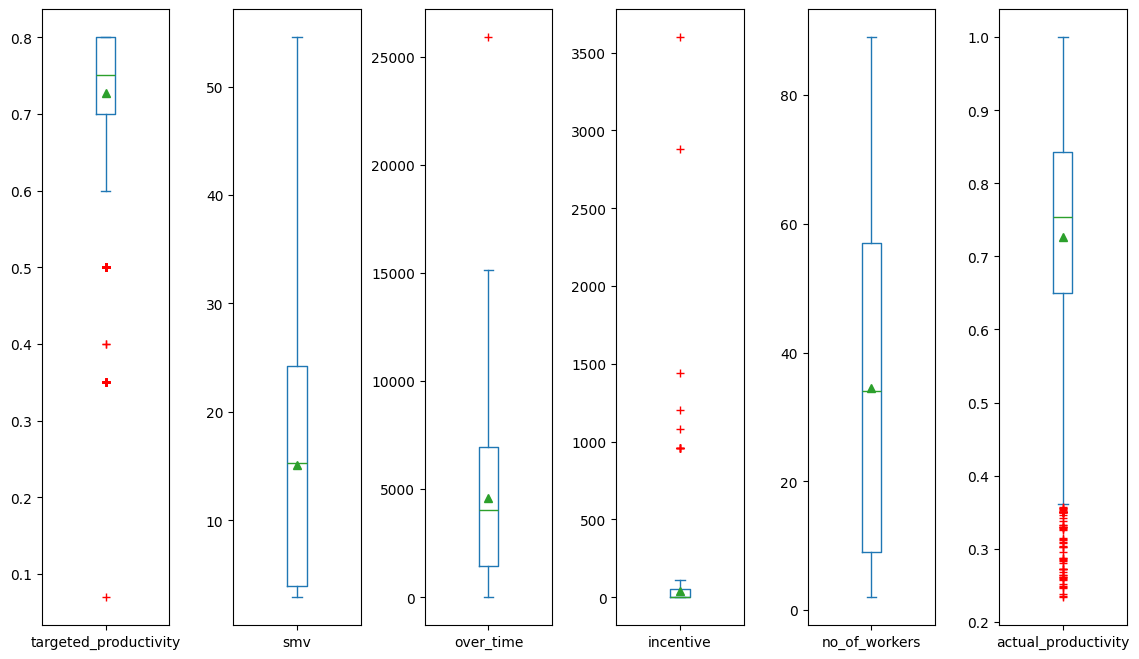

In [23]:
Garment_worker.plot(
    kind='box',
    subplots=True,
    sharey=False,
    figsize=(14,8),
    showmeans=True,
    flierprops=dict(markeredgecolor='r',marker='+'),
)

plt.subplots_adjust(wspace=0.5)
plt.show()

From this box plot, it is possible to detect that in some variables there are outliers that may or may not be removed, depending on the context and what they represent in their corresponding characteristic.

- **targeted_productivity:** Since it represents a productivity goal to be achieved, it would be normal for it to always have values close to 1. However, the fact that it is a goal does not mean that other variables that can decrease performance should be ignored, so it would be normal for it to have a medium or even low value in certain scenarios (e.g., lack of personnel + interruptions + a lot of work in delay, etc.) where the conditions will be unfavorable for the employees. Despite this, it is considered very strange to set a productivity goal below 0.1, so these values will be removed.

- **over_time:** It only has a single outlier above 25,000 minutes. Although it may be an achievable value, the truth is that this may be unlikely, therefore, it is decided to remove it since it is not considered to significantly affect the result of the analysis and prediction. The decision is made to remove all values above 25,000.

- **incentive:** No outliers will be removed since, being financial incentives, they can vary at certain times or in a process with a certain special priority, so it may be normal for high and unusual values to occur more frequently than in the previous variable.

- **actual_productivity:** Here it is shown that the normal productivity of employees tends to be medium to high, however, on some occasions, low productivity usually occurs. These outliers are completely normal because there may be days that for any type of circumstances and unforeseen events, the processes have been affected and therefore low productivity has been generated, which can happen on many occasions. For this reason, these outliers will not be removed.

In [28]:
# We will only take the values where the target productivity is greater than 0.1 and the overtime is less than 25000.
Garment_worker = Garment_worker[(Garment_worker['targeted_productivity'] > 0.1) & (Garment_worker['over_time'] < 25000)]

The boxplot is made again to observe the changes.

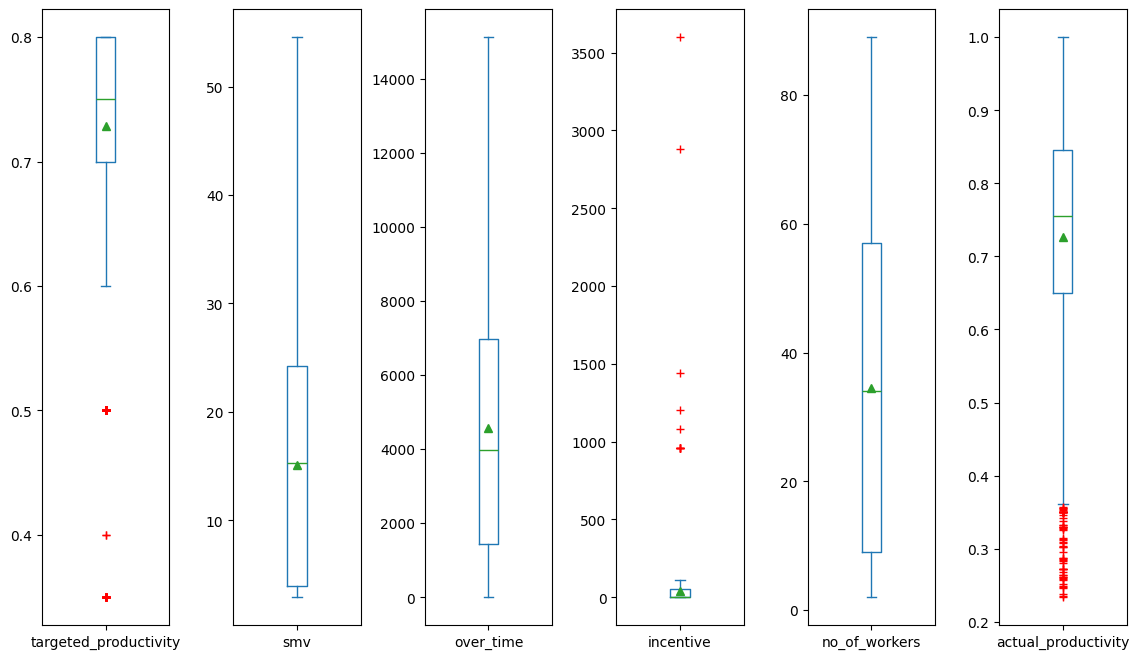

In [25]:
Garment_worker.plot(
    kind='box',
    subplots=True,
    sharey=False,
    figsize=(14,8),
    showmeans=True,
    flierprops=dict(markeredgecolor='r',marker='+'),
)

plt.subplots_adjust(wspace=0.5)
plt.show()

In [26]:
Garment_worker.head()

date  department       day  targeted_productivity    smv  over_time  \
0  1/1/2015      sweing  Thursday                   0.80  26.16       7080   
1  1/1/2015  finishing   Thursday                   0.75   3.94        960   
2  1/1/2015      sweing  Thursday                   0.80  11.41       3660   
4  1/1/2015      sweing  Thursday                   0.80  25.90       1920   
5  1/1/2015      sweing  Thursday                   0.80  25.90       6720   

   incentive  no_of_workers  actual_productivity  
0         98           59.0             0.940725  
1          0            8.0             0.886500  
2         50           30.5             0.800570  
4         50           56.0             0.800382  
5         38           56.0             0.800125

In [7]:
Garment_worker.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1158 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1158 non-null   object 
 1   quarter                1158 non-null   object 
 2   department             1158 non-null   object 
 3   day                    1158 non-null   object 
 4   team                   1158 non-null   int64  
 5   targeted_productivity  1158 non-null   float64
 6   smv                    1158 non-null   float64
 7   wip                    664 non-null    float64
 8   over_time              1158 non-null   int64  
 9   incentive              1158 non-null   int64  
 10  idle_time              1158 non-null   float64
 11  idle_men               1158 non-null   int64  
 12  no_of_style_change     1158 non-null   int64  
 13  no_of_workers          1158 non-null   float64
 14  actual_productivity    1158 non-null   float64
dtypes: float6

In [29]:
Garment_worker.describe()

targeted_productivity          smv     over_time    incentive  \
count            1149.000000  1149.000000   1149.000000  1149.000000   
mean                0.728634    15.090087   4565.892080    37.290688   
std                 0.096534    11.013280   3295.056396   163.042979   
min                 0.350000     2.900000      0.000000     0.000000   
25%                 0.700000     3.940000   1440.000000     0.000000   
50%                 0.750000    15.260000   3960.000000     0.000000   
75%                 0.800000    24.260000   6960.000000    50.000000   
max                 0.800000    54.560000  15120.000000  3600.000000   

       no_of_workers  actual_productivity  
count    1149.000000          1149.000000  
mean       34.477372             0.726360  
std        22.175052             0.168908  
min         2.000000             0.233705  
25%         9.000000             0.650134  
50%        34.000000             0.755167  
75%        57.000000             0.845069  
max        89.000000             0.999995

### Data Transformation

For this analysis and the task to be performed, no transformation is necessary since there is no data to convert to categorical, and there is no need to generate a new variable from others. However, a modification will be made to the `department` variable.

This will be done because when reviewing the report generated with profile, it can be observed that it has 3 unique values: `sweing`, `finishing`, `finishing `, where one is clearly repeated. This happens because one label is 'finishing' and the other is 'finishing ', that is, there is an additional space that the code takes into account as a value and therefore, it seems to be another category (which was surely an error by the person who organized the dataset). To solve this, all values where the 'department' variable is equal to 'finishing ' will be taken and their label will be changed to 'finishing', thus having two unique values, which means that there would be two departments to consider: the sewing department (sweing) and the finishing department (finishing).

In [30]:
Garment_worker['department'].unique() # Observe the unique values of the variable.

array(['sweing', 'finishing ', 'finishing'], dtype=object)

In [31]:
# Replace the labels 'finishing ' with 'finishing' in the 'department' column
Garment_worker.loc[Garment_worker['department'] == 'finishing ', 'department'] = 'finishing'

In [32]:
Garment_worker['department'].unique() # Check that the number of unique values has changed.

array(['sweing', 'finishing'], dtype=object)

## 3. Data Visualization

### Actual Productivity vs. Days of the Week

We want to obtain a histogram that allows us to observe the average productivity for each day of the week (not counting Friday since there is no such label in the dataset. Perhaps it was an error in data collection or they do not work on those days), which would provide the possibility of knowing which days tend to have higher and lower productivity.

**Conclusion:**
Upon obtaining the graph, it can be concluded that, on average, the days with the highest productivity are Saturdays and Tuesdays. It is noteworthy that there is not as much variation as one might think.

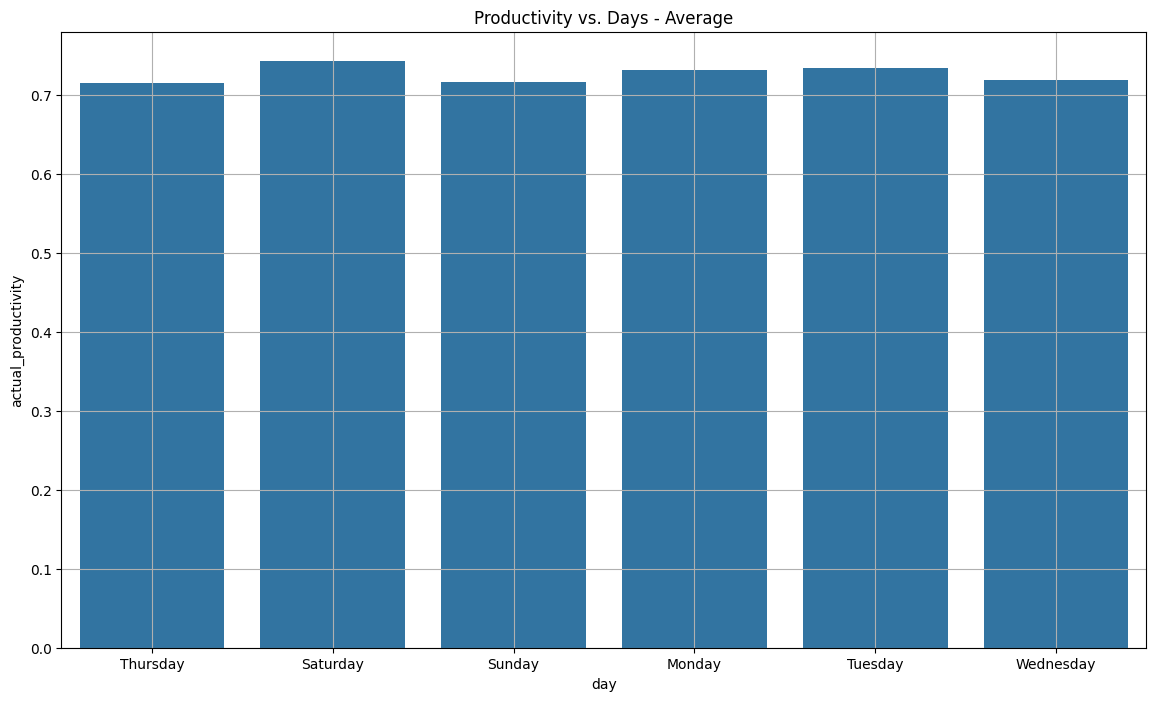

In [33]:
plt.figure(figsize=(14, 8))

sn.barplot(
    x="day", 
    y="actual_productivity", 
    data=Garment_worker, 
    estimator='mean', 
    errorbar=None
)
plt.title('Productivity vs. Days - Average')
plt.grid()
plt.show()

### Actual Productivity vs. Date

We want to obtain a graph that allows us to know the variation of productivity for each month of the year, which would generate the possibility of devising strategies to solve or improve productivity as a certain date approaches.

In [34]:
# Convert the date column to a datetime format.
Garment_worker['date'] = pd.to_datetime(Garment_worker['date'])

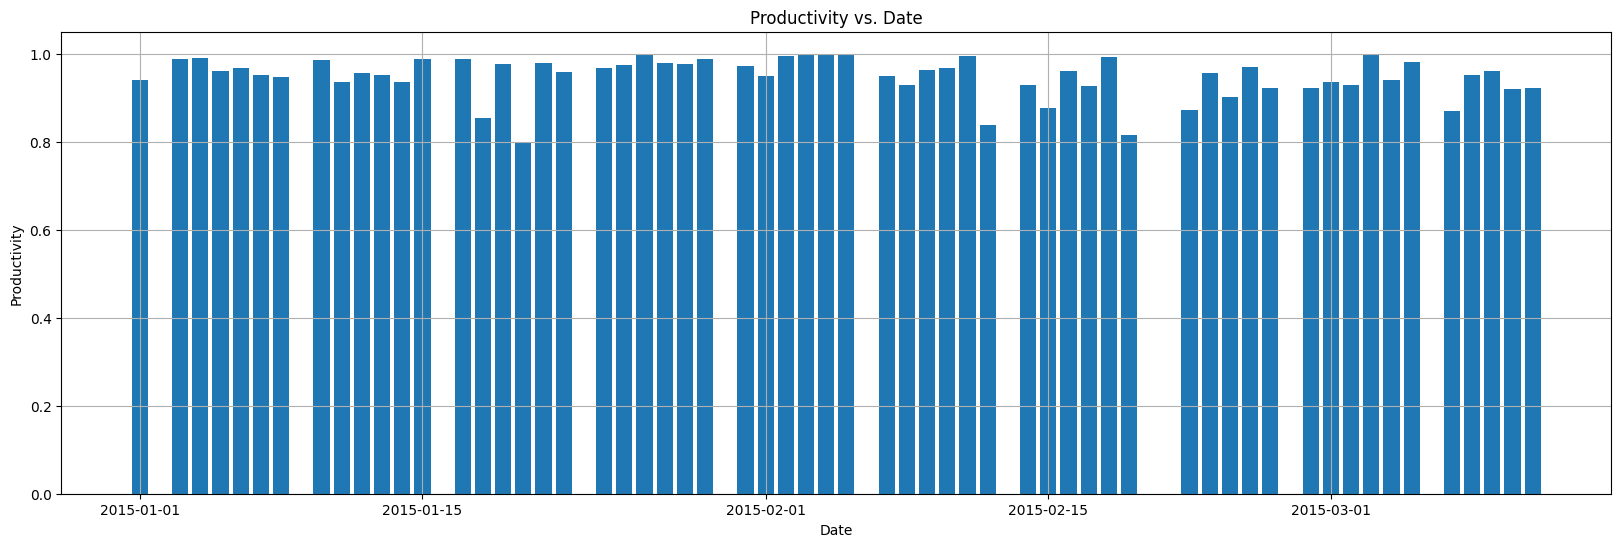

In [35]:
plt.figure(figsize=(20, 6))
plt.bar(Garment_worker['date'], Garment_worker['actual_productivity'])
plt.title('Productivity vs. Date')
plt.xlabel('Date')
plt.ylabel('Productivity')

plt.grid()
plt.show()

**Observations:**
Observing the previous graph, it can be seen that curiously, in the second half of each month, there is a decrease in productivity, compared to the first half of the month. To verify this in a better way, it is considered prudent to obtain a graph where the 5 days with the highest productivity and the 5 days with the lowest productivity are observed.

**Conclusion:**
Since the data was only collected for 3 months, it is difficult to draw a very elaborate conclusion as much more data would be needed to observe a significant trend.

In [36]:
# Group the days of each month with the corresponding actual productivity and get the average.
most_prod_day = Garment_worker.groupby(Garment_worker['date'].dt.day)['actual_productivity'].mean().reset_index()

In [37]:
most_prod_day.sort_values(by = 'actual_productivity', ascending=False, inplace=True)

less_prod_day = most_prod_day.sort_values(by = 'actual_productivity', ascending = True)

In [38]:
# Convert the days to categorical so that when graphing, it is not reorganized by higher or lower numerical value of the day.
most_prod_day['date'] = most_prod_day['date'].astype(str)
less_prod_day['date'] = less_prod_day['date'].astype(str)

In [39]:
most_prod_day[0:5] # 5 days with the highest productivity

date  actual_productivity
29   31             0.828725
5     6             0.805508
28   29             0.780666
4     5             0.772248
9    10             0.762175

In [40]:
less_prod_day[0:5] # 5 days with the lowest productivity.

date  actual_productivity
27   28             0.662217
21   22             0.665651
19   20             0.673743
17   18             0.673829
15   16             0.681059

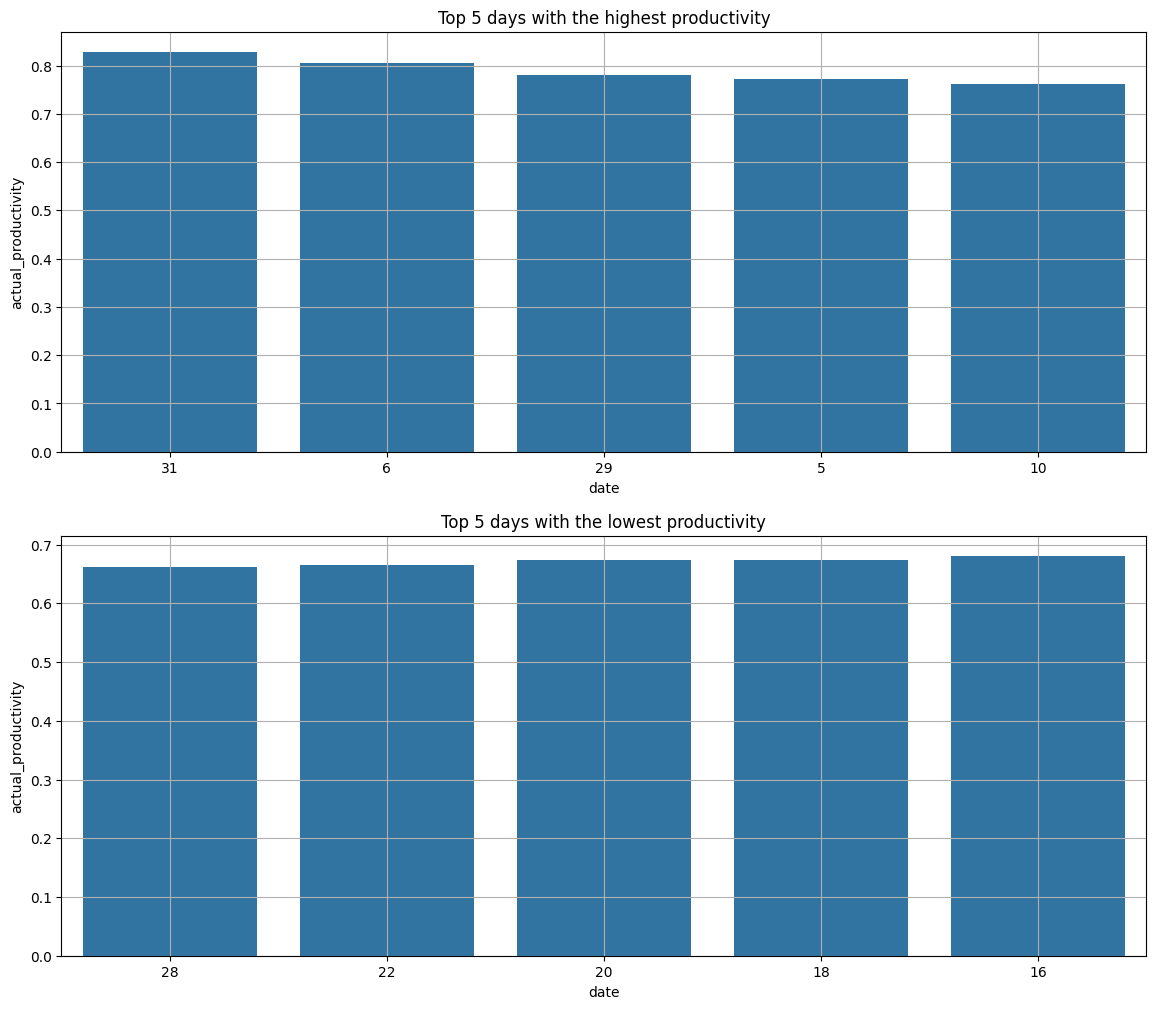

In [41]:
plt.figure(figsize=(14, 12))
plt.subplot(2,1,1)

sn.barplot(
    x = 'date',
    y = 'actual_productivity',
    data=most_prod_day[0:5],  
    errorbar=None,
)
plt.title('Top 5 days with the highest productivity')
plt.grid()

plt.subplot(2,1,2)

sn.barplot(
    x = 'date',
    y = 'actual_productivity',
    data=less_prod_day[0:5],  
    errorbar=None, 
)
plt.title('Top 5 days with the lowest productivity')
plt.grid()
plt.show()

### Actual Productivity vs. Targeted Productivity

We want to visualize the trend of actual productivity with respect to a proposed goal. What we would expect to see is a linear trend where the higher the target productivity, the higher the actual productivity. This representation will be done using a scatter plot to better observe the behavior.

In [41]:
# Group the target productivity with the actual productivity and get the average.
tar_x_act = Garment_worker.groupby(Garment_worker['targeted_productivity'])['actual_productivity'].mean().reset_index()

**Conclusion:**
When making the scatter plot, a linear trend can be observed, with only one exception for the first value, which despite having a low goal, showed a higher performance. Through this graph, it is possible to realize that the higher the target productivity, the higher the actual productivity. But it also reflects that a low target will not always produce a low actual result.

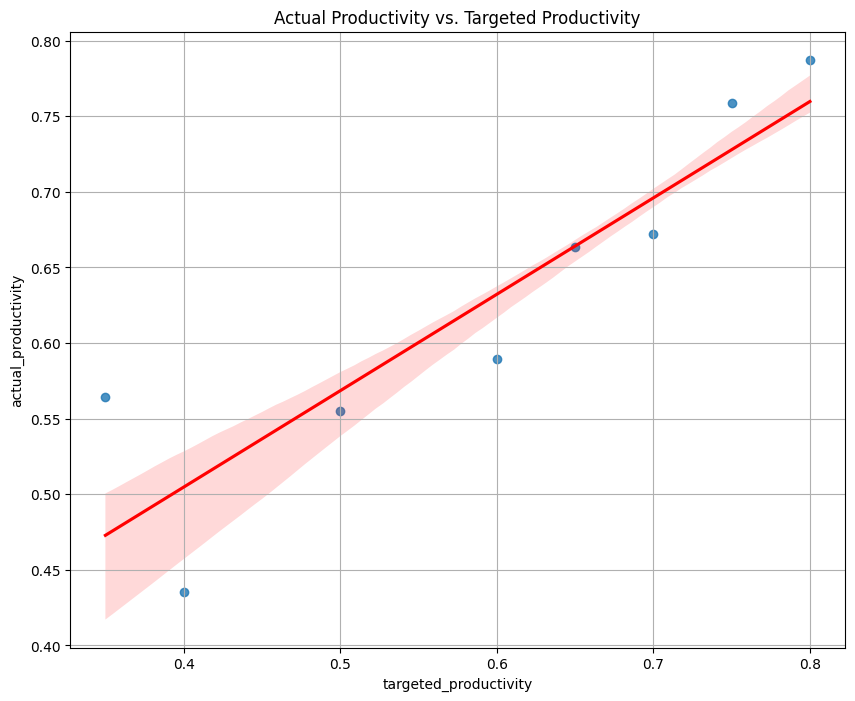

In [42]:
plt.figure(figsize = (10, 8))
#sn.scatterplot(data = tar_x_act, x = 'targeted_productivity', y = 'actual_productivity')
sn.regplot(x = 'targeted_productivity', y = 'actual_productivity', data = tar_x_act, marker='o', line_kws=dict(color='r'), ci = 40)
plt.title('Actual Productivity vs. Targeted Productivity')
plt.grid()
plt.show()

### Actual Productivity vs. Department

With this graph, we want to make a simple comparison to know which of the two departments tends to have higher productivity, so a histogram will be used to observe the average productivity of both departments.

**Conclusion:**
This showed that the finishing department tends to have better productivity than the sewing department, which could be associated with the complexity of each job, the environment, or even the personnel who perform each task. This could lead to a deeper analysis at the business level.

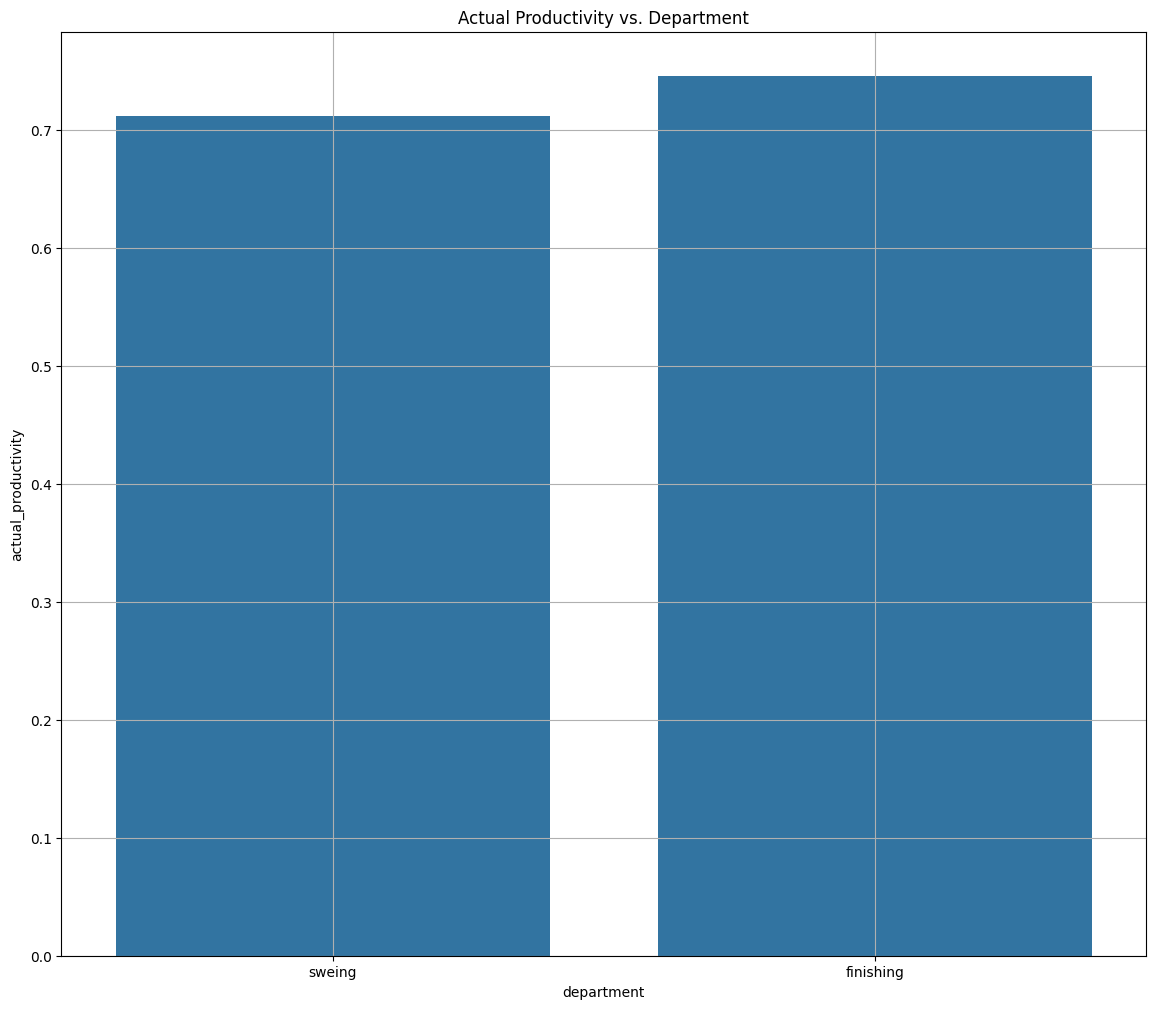

In [43]:
plt.figure(figsize=(14, 12))

sn.barplot(
    x = 'department',
    y = 'actual_productivity',
    data=Garment_worker,
    estimator='mean',
    errorbar=None,
)
plt.title('Actual Productivity vs. Department')
plt.grid()
plt.show()

## 4. Correlation Analysis

### Supervised Correlation Analysis

From this point on, the focus of the development will be dedicated to the modeling part. This is because, depending on the analyses performed, there will be a removal of variables, changes in the scale of the data, etc., in order to obtain a more efficient and accurate model for making predictions.

In this supervised correlation analysis, we want to know which variables have a high correlation with the target variable, which in this case is `actual_productivity`. In this way, we could identify the variables that, with respect to this variable, are providing the same information, so one (or more, if necessary) of them could be removed to make both the training and the final prediction lighter.

It is important to remember that for a model to make a prediction, it receives input parameters, which makes it more interesting because if it is possible to obtain a good (or better) prediction with fewer parameters, the task will be done more quickly.

Since there are string-type labels in the dataset, it will be a problem when doing both the modeling and other analyses because we can only work with numerical variables. For this reason, the `preprocessing` library from Sklearn will be used, which allows encoding the labels into numerical values. This will be applied to `department` and `day`, as they are the ones with string-type labels.

In [44]:
le = preprocessing.LabelEncoder() # Object to encode the labels numerically

In [45]:
Garment_worker['department'].unique() # View the unique values and the order in which they appear.

array(['sweing', 'finishing'], dtype=object)

In [46]:
Garment_worker['day'].unique() # View the unique values and the order in which they appear.

array(['Thursday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday'],
      dtype=object)

In [47]:
Garment_worker['department'] = le.fit_transform(Garment_worker['department']) # Encode the labels of the 'department' column

In [48]:
# View the new unique values and the order in which they appear to associate them with the ones we had before encoding.
Garment_worker['department'].unique() # 1 = 'sweing', 0 = 'finishing'

array([1, 0])

In [49]:
# View the new unique values and the order in which they appear to associate them with the ones we had before encoding.
Garment_worker['day'] = le.fit_transform(Garment_worker['day']) # Encode the labels of the 'day' column

In [50]:
Garment_worker['day'].unique() # 3 = 'Thursday', 1 = 'Saturday', 2 = 'Sunday', 0 = 'Monday', 4 = 'Tuesday', 5 = 'Wednesday'

array([3, 1, 2, 0, 4, 5])

Once the data has been prepared, we proceed to obtain a heatmap that shows the correlation between the variables. As already mentioned, in this case, we will only visualize the `actual_productivity` row and the correlation that the rest of the columns have with it.

**Conclusion:**
In this case, no variable has a high enough correlation to make the decision to remove it, so in this analysis, the dataset will remain intact.

*It is highlighted that the highest correlation (and also, positive) was obtained with the 'targeted_productivity' variable, which reinforces the analysis previously performed in its respective graphical representation.*

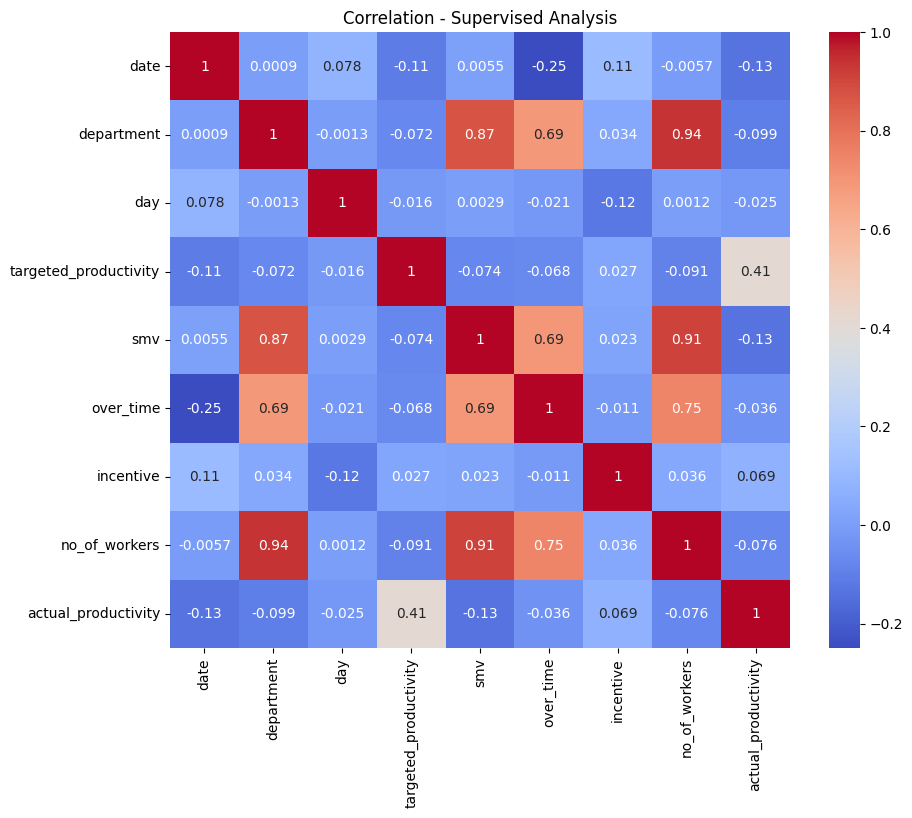

In [51]:
plt.figure(figsize=(10,8))
sn.heatmap(Garment_worker.corr(), cmap="coolwarm", annot=True)
plt.title('Correlation - Supervised Analysis')
plt.show()

### Unsupervised Correlation Analysis

This analysis is exactly the same as the previous one, with the difference that the target variable (the one we want to predict or classify) is not taken into account, but rather the relationship between the rest of the variables is observed, which would allow us to make the decision to remove any of them that are providing very similar information, that is, that one of them can explain the other, so both are not necessary.

**Conclusion:**
Observing the correlation matrix, it is possible to realize that there is a high correlation between 3 variables: `department`, `smv`, and `no_of_workers`. For this reason, with `no_of_workers` being the common factor with which the remaining variables reach a higher correlation, we will choose to remove only the 'no_of_workers' variable, since after that, the correlation between `smv` and `department` will be 0.87, which is not considered high enough to remove another variable.

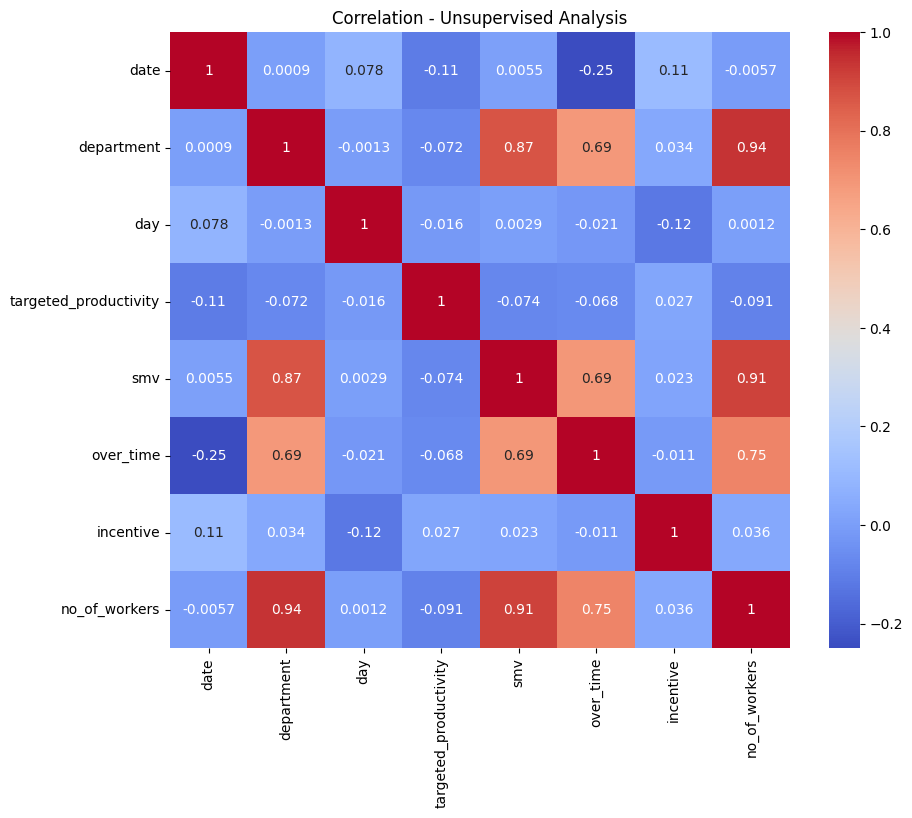

In [52]:
plt.figure(figsize=(10,8))
sn.heatmap(Garment_worker.iloc[:, 0:-1].corr(), cmap="coolwarm", annot=True) # All columns except the last one
plt.title('Correlation - Unsupervised Analysis')
plt.show()

From now on, we will work with a new variable so as not to modify the original one that has been used so far.

In [53]:
data_GW = Garment_worker.drop(['no_of_workers'], axis=1) # Remove the 'no_of_workers' column

In [54]:
data_GW.head()

date  department  day  targeted_productivity    smv  over_time  \
0 2015-01-01           1    3                   0.80  26.16       7080   
1 2015-01-01           0    3                   0.75   3.94        960   
2 2015-01-01           1    3                   0.80  11.41       3660   
4 2015-01-01           1    3                   0.80  25.90       1920   
5 2015-01-01           1    3                   0.80  25.90       6720   

   incentive  actual_productivity  
0         98             0.940725  
1          0             0.886500  
2         50             0.800570  
4         50             0.800382  
5         38             0.800125

In [55]:
data_GW.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1149 entries, 0 to 1196
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   1149 non-null   datetime64[ns]
 1   department             1149 non-null   int32         
 2   day                    1149 non-null   int32         
 3   targeted_productivity  1149 non-null   float64       
 4   smv                    1149 non-null   float64       
 5   over_time              1149 non-null   int64         
 6   incentive              1149 non-null   int64         
 7   actual_productivity    1149 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int32(2), int64(2)
memory usage: 71.8 KB


The correlation matrix is visualized again.

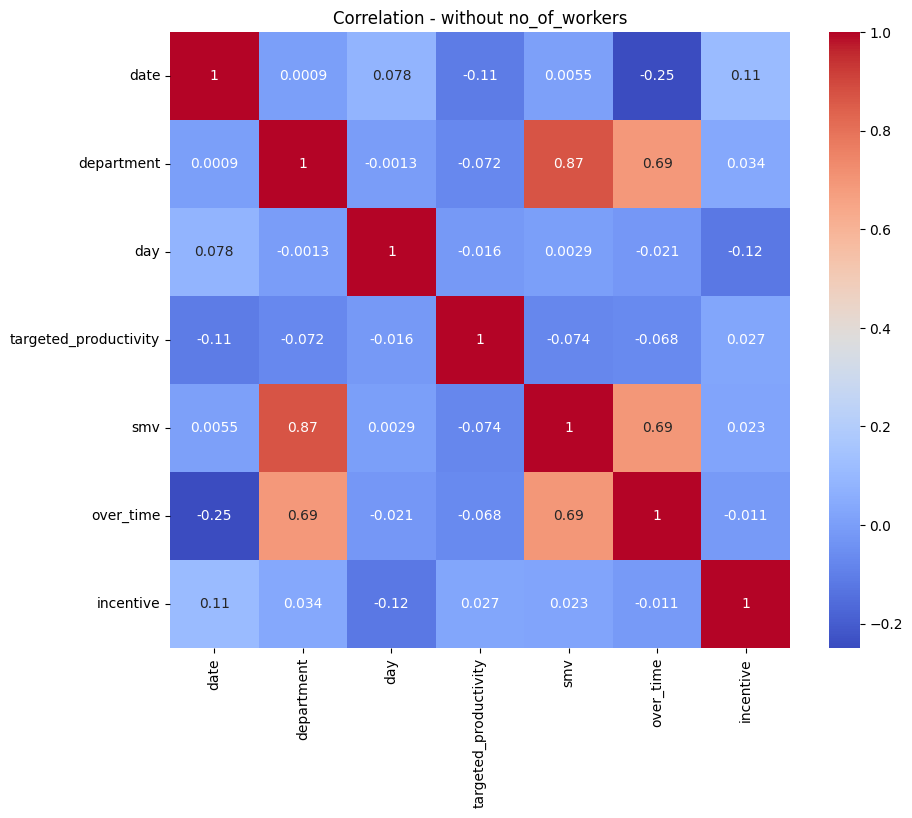

In [56]:
plt.figure(figsize=(10,8))
sn.heatmap(data_GW.iloc[:, 0:-1].corr(), cmap="coolwarm", annot=True) # All columns except the last one
plt.title('Correlation - without no_of_workers')
plt.show()

## 5. Modeling

From now on, we will start working on everything related to the development of the prediction model. For this, a new analysis of the statistical description of the data will be done, a standardization of the same, partition into training and test data, etc. All with the aim of training a regression model that allows predicting the actual productivity that employees will have given certain parameters.

### Data Transformation

To perform a correct training, in most cases it is very important to visualize the distribution of the data. This is because if the scale of each variable is very different from the rest, it could generate a bias in the model, possibly giving more relevance to the variables that have a larger range of values. In addition, the data is usually brought to a Gaussian distribution since a large part of the models are based on this distribution.

In [57]:
data_GW.describe()

date   department          day  \
count                           1149  1149.000000  1149.000000   
mean   2015-02-04 08:55:08.616188160     0.577023     2.528285   
min              2015-01-01 00:00:00     0.000000     0.000000   
25%              2015-01-17 00:00:00     0.000000     1.000000   
50%              2015-02-03 00:00:00     1.000000     3.000000   
75%              2015-02-24 00:00:00     1.000000     4.000000   
max              2015-03-11 00:00:00     1.000000     5.000000   
std                              NaN     0.494247     1.719516   

       targeted_productivity          smv     over_time    incentive  \
count            1149.000000  1149.000000   1149.000000  1149.000000   
mean                0.728634    15.090087   4565.892080    37.290688   
min                 0.350000     2.900000      0.000000     0.000000   
25%                 0.700000     3.940000   1440.000000     0.000000   
50%                 0.750000    15.260000   3960.000000     0.000000   
75%                 0.800000    24.260000   6960.000000    50.000000   
max                 0.800000    54.560000  15120.000000  3600.000000   
std                 0.096534    11.013280   3295.056396   163.042979   

       actual_productivity  
count          1149.000000  
mean              0.726360  
min               0.233705  
25%               0.650134  
50%               0.755167  
75%               0.845069  
max               0.999995  
std               0.168908

Before proceeding to the next procedure, a new transformation is made, which will consist of separating the date data into 3 columns: day, month, year. This is because it is not possible to work with data in date format, but by dividing them into several columns, it represents the same information in numerical format.

In [58]:
# Create new columns by extracting the individual information from the 'date' column.
data_GW['day_y'] = data_GW['date'].dt.day
data_GW['month'] = data_GW['date'].dt.month
data_GW['year'] = data_GW['date'].dt.year

In [59]:
data_GW.drop(['date'], axis = 1, inplace=True) # Remove the 'date' column

In [60]:
data_GW.head()

department  day  targeted_productivity    smv  over_time  incentive  \
0           1    3                   0.80  26.16       7080         98   
1           0    3                   0.75   3.94        960          0   
2           1    3                   0.80  11.41       3660         50   
4           1    3                   0.80  25.90       1920         50   
5           1    3                   0.80  25.90       6720         38   

   actual_productivity  day_y  month  year  
0             0.940725      1      1  2015  
1             0.886500      1      1  2015  
2             0.800570      1      1  2015  
4             0.800382      1      1  2015  
5             0.800125      1      1  2015

In [61]:
data_GW.describe()

department          day  targeted_productivity          smv  \
count  1149.000000  1149.000000            1149.000000  1149.000000   
mean      0.577023     2.528285               0.728634    15.090087   
std       0.494247     1.719516               0.096534    11.013280   
min       0.000000     0.000000               0.350000     2.900000   
25%       0.000000     1.000000               0.700000     3.940000   
50%       1.000000     3.000000               0.750000    15.260000   
75%       1.000000     4.000000               0.800000    24.260000   
max       1.000000     5.000000               0.800000    54.560000   

          over_time    incentive  actual_productivity        day_y  \
count   1149.000000  1149.000000          1149.000000  1149.000000   
mean    4565.892080    37.290688             0.726360    13.548303   
std     3295.056396   163.042979             0.168908     8.578017   
min        0.000000     0.000000             0.233705     1.000000   
25%     1440.000000     0.000000             0.650134     7.000000   
50%     3960.000000     0.000000             0.755167    12.000000   
75%     6960.000000    50.000000             0.845069    21.000000   
max    15120.000000  3600.000000             0.999995    31.000000   

             month    year  
count  1149.000000  1149.0  
mean      1.721497  2015.0  
std       0.750655     0.0  
min       1.000000  2015.0  
25%       1.000000  2015.0  
50%       2.000000  2015.0  
75%       2.000000  2015.0  
max       3.000000  2015.0

### Data Partitioning

When training a model, it is important to provide it with training and test data, so that with the former, it can train and find patterns that allow it to predict the target variable, and with the latter, compare if the predictions are close to reality.

In [62]:
X = data_GW.drop(['actual_productivity'], axis = 1) # Get all the data except the target variable
y = data_GW['actual_productivity'] # Get the data of only the target variable

In [63]:
# Divide the data into training and test, where 20% will be for testing and 80% for training.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

### Standardization
When visualizing the statistical information, it can be observed that there is a clear difference in the scales, as there are values that go from 0 to 1, but others that go up to more than 15,000, in addition to the fact that the standard deviation of each characteristic varies a lot. For this reason, a standardization will be performed on the training and test data, in order to bring the values to a Gaussian distribution with a standard deviation of 1 and a mean of 0.

In [64]:
scaler = StandardScaler() # Object to apply the standardization.

scaler.fit(X_train) # The scaler is adjusted with respect to the training data.

StandardScaler()

In [65]:
# The transformations are made to each set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

After performing the above, the data changed its distribution, so they can no longer be identified as they have been until now (for example, '2015' will no longer be used to represent the year the data was taken).

In [66]:
X_train[0:5] # First 5 rows of the training data after standardization.

array([[-1.15947736,  0.25844536,  0.74450934, -1.00060867, -0.58666061,
        -0.26147229, -1.02527969,  0.37850506,  0.        ],
       [ 0.86245755, -1.47100574,  0.23429004,  0.335509  , -0.14890296,
        -0.26147229, -0.55639089,  0.37850506,  0.        ],
       [-1.15947736, -0.31803834, -2.31680646, -0.8935393 , -0.84201924,
        -0.26147229,  0.96749769,  0.37850506,  0.        ],
       [ 0.86245755, -1.47100574, -0.27592926,  1.35311781,  0.76309213,
        -0.05627551,  0.2641645 ,  0.37850506,  0.        ],
       [ 0.86245755,  0.25844536, -0.27592926,  1.05800225,  0.76309213,
         0.11852176, -1.02527969,  1.72674596,  0.        ]])

## 6. Model Application

Finally, after having done all the above, it remains to implement, train, and test the Machine Learning model in charge of predicting the actual productivity of the employees. For this, 5 regression models will be used to compare them and select the one that provides the best performance, all this supported by the MLflow tool, which allows obtaining a record of each one and packaging the best models.

The models to be implemented are:

- Linear Regression
- Decision Tree Regressor
- Random Forest Regressor
- Lasso Regression
- Ridge Regression

In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import r2_score as rs

From this moment on, the process of training the 5 models and obtaining metrics will be carried out. The process will be done manually with each model because it was not possible to implement *AutoML*, so it was decided to do it this way.

In [70]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080") # Set MLflow tracking server URI

# Note: Execute python -m mlflow ui --port 8080 in the terminal to start the MLflow server before running the code below.

### Linear Regression

In [ ]:
mlflow.set_experiment('GarmentWorkers-Productivity') # Define the name of the experiment where the results will be saved

with mlflow.start_run(run_name='Linear Regression') as run:

    mlflow.sklearn.autolog() # For automatic tracking

    # Model training
    Lreg = LinearRegression().fit(X_train, y_train)

    # Prediction with test variables
    Lreg_predict = Lreg.predict(X_test)

    # Obtaining regression metrics
    scoringLr = {'MAE': mae(y_test, Lreg_predict), 'MSE': mse(y_test, Lreg_predict), 'RMSE': rmse(y_test, Lreg_predict), 'R2': rs(y_test, Lreg_predict)}

    # Manual tracking to ensure obtaining metrics of interest
    mlflow.log_metric('MAE', scoringLr['MAE'])
    mlflow.log_metric('MSE', scoringLr['MSE'])
    mlflow.log_metric('RMSE', scoringLr['RMSE'])
    mlflow.log_metric('R2', scoringLr['R2'])

    # Obtaining training metrics
    signature = infer_signature(X_train, Lreg.predict(X_train))
    
    model_info = mlflow.sklearn.log_model(
        sk_model=Lreg,
        artifact_path="Linear Regression",
        signature=signature,
        input_example=X_train,
        registered_model_name="Sklearn_LR",
    )

### Decision Tree Regression

In [ ]:
mlflow.set_experiment('GarmentWorkers-Productivity') # Define the name of the experiment where the results will be saved

with mlflow.start_run(run_name='Decision Tree Regression') as run:

    mlflow.sklearn.autolog() # For automatic tracking

    # Model training
    DTR = DecisionTreeRegressor().fit(X_train, y_train)

    # Prediction with test variables
    DTR_predict = DTR.predict(X_test)

    # Obtaining regression metrics
    scoringDTR = {'MAE': mae(y_test, DTR_predict), 'MSE': mse(y_test, DTR_predict), 'RMSE': rmse(y_test, DTR_predict), 'R2': rs(y_test, DTR_predict)}

    # Manual tracking to ensure obtaining metrics of interest
    mlflow.log_metric('MAE', scoringDTR['MAE'])
    mlflow.log_metric('MSE', scoringDTR['MSE'])
    mlflow.log_metric('RMSE', scoringDTR['RMSE'])
    mlflow.log_metric('R2', scoringDTR['R2'])

    # Obtaining training metrics
    signature = infer_signature(X_train, DTR.predict(X_train))
    
    model_info = mlflow.sklearn.log_model(
        sk_model=DTR,
        artifact_path="Decision Tree Regression",
        signature=signature,
        input_example=X_train,
        registered_model_name="Sklearn_DTR",
    )

### Random Forest Regression

In [ ]:
mlflow.set_experiment('GarmentWorkers-Productivity') # Define the name of the experiment where the results will be saved

with mlflow.start_run(run_name='Random Forest Regression') as run:

    mlflow.sklearn.autolog() # For automatic tracking

    # Model training
    RFR = RandomForestRegressor().fit(X_train, y_train)

    # Prediction with test variables
    RFR_predict = RFR.predict(X_test)

    # Obtaining regression metrics
    scoringRFR = {'MAE': mae(y_test, RFR_predict), 'MSE': mse(y_test, RFR_predict), 'RMSE': rmse(y_test, RFR_predict), 'R2': rs(y_test, RFR_predict)}

    # Manual tracking to ensure obtaining metrics of interest
    mlflow.log_metric('MAE', scoringRFR['MAE'])
    mlflow.log_metric('MSE', scoringRFR['MSE'])
    mlflow.log_metric('RMSE', scoringRFR['RMSE'])
    mlflow.log_metric('R2', scoringRFR['R2'])

    # Obtaining training metrics
    signature = infer_signature(X_train, RFR.predict(X_train))
    
    model_info = mlflow.sklearn.log_model(
        sk_model=RFR,
        artifact_path="Random Forest Regression",
        signature=signature,
        input_example=X_train,
        registered_model_name="Sklearn_RFR",
    )

### Lasso Regression

In [ ]:
mlflow.set_experiment('GarmentWorkers-Productivity') # Define the name of the experiment where the results will be saved

with mlflow.start_run(run_name='Lasso Regression') as run:

    mlflow.sklearn.autolog() # For automatic tracking

    # Model training
    lasso = linear_model.Lasso().fit(X_train, y_train)

    # Prediction with test variables
    lasso_predict = lasso.predict(X_test)

    # Obtaining regression metrics
    scoringLasso = {'MAE': mae(y_test, lasso_predict), 'MSE': mse(y_test, lasso_predict), 'RMSE': rmse(y_test, lasso_predict), 'R2': rs(y_test, lasso_predict)}

    # Manual tracking to ensure obtaining (test) metrics of interest
    mlflow.log_metric('MAE', scoringLasso['MAE'])
    mlflow.log_metric('MSE', scoringLasso['MSE'])
    mlflow.log_metric('RMSE', scoringLasso['RMSE'])
    mlflow.log_metric('R2', scoringLasso['R2'])

    # Obtaining training metrics
    signature = infer_signature(X_train, lasso.predict(X_train))
    
    model_info = mlflow.sklearn.log_model(
        sk_model=lasso,
        artifact_path="Lasso Regression",
        signature=signature,
        input_example=X_train,
        registered_model_name="Sklearn_Lasso",
    )

### Ridge Regression

In [ ]:
mlflow.set_experiment('GarmentWorkers-Productivity') # Define the name of the experiment where the results will be saved

with mlflow.start_run(run_name='Ridge Regression') as run:

    mlflow.sklearn.autolog() # For automatic tracking

    # Model training
    ridge = Ridge().fit(X_train, y_train)

    # Prediction with test variables
    ridge_predict = ridge.predict(X_test)

    # Obtaining regression metrics
    scoringRidge = {'MAE': mae(y_test, ridge_predict), 'MSE': mse(y_test, ridge_predict), 'RMSE': rmse(y_test, ridge_predict), 'R2': rs(y_test, ridge_predict)}

    # Manual tracking to ensure obtaining metrics of interest
    mlflow.log_metric('MAE', scoringRidge['MAE'])
    mlflow.log_metric('MSE', scoringRidge['MSE'])
    mlflow.log_metric('RMSE', scoringRidge['RMSE'])
    mlflow.log_metric('R2', scoringRidge['R2'])

    # Obtaining training metrics
    signature = infer_signature(X_train, ridge.predict(X_train))
    
    model_info = mlflow.sklearn.log_model(
        sk_model=ridge,
        artifact_path="RidgeRegression",
        signature=signature,
        input_example=X_train,
        registered_model_name="Sklearn_Ridge",
    )

## 7. Model Comparison
Now we proceed to organize all the metrics in a DataFrame to make the comparison.

In [77]:
metrics = pd.DataFrame(index = ['MAE', 'MSE', 'RMSE', 'R2'], columns = ['LR', 'DTR', 'RFR', 'Lasso', 'Ridge'])

In [78]:
metrics['LR'] = scoringLr.values()
metrics['DTR'] = scoringDTR.values()
metrics['RFR'] = scoringRFR.values()
metrics['Lasso'] = scoringLasso.values()
metrics['Ridge'] = scoringRidge.values()

In [79]:
metrics

LR       DTR       RFR     Lasso     Ridge
MAE   0.107968  0.089074  0.073103  0.130764  0.107967
MSE   0.022130  0.022269  0.013995  0.028132  0.022130
RMSE  0.148762  0.149229  0.118301  0.167726  0.148761
R2    0.213083  0.208133  0.502354 -0.000344  0.213092

**Conclusion:**
Through the table, it can be observed that the model with the best performance for **predicting the actual productivity** of the employees is the *Random Forest Regression*, which obtained the lowest errors and, in turn, the highest coefficient of determination.

## 8. Final Prediction Example
Finally, once the model to be used has been chosen, it can be packaged and used more efficiently through the artifacts generated in MLflow, as follows.

In [ ]:
from pyspark.sql.functions import struct, col

# Path to the artifact
logged_model = 'mlartifacts\Random Forest Regression'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

testData = X_test[100, :].reshape(-1, 9) # Select the data from a row and resize it so that the model can read it.
predictedData = loaded_model.predict(pd.DataFrame(testData)) # Send that row to the model
actualData = np.array(y_test)[100] # Get the real value for the row being tested.

Finally, a prediction attempt can be made using a row from the test set and its corresponding real value as the data source, to compare the predicted data with the real data.

In [90]:
print(f'For the data: {testData}\nA prediction was obtained that the actual productivity would be: {predictedData}\nAnd it was actually: {actualData}')

For the data: [[-1.15947736 -1.47100574  0.74450934 -1.00060867 -0.95145865 -0.26147229
  -0.2047243  -0.96973583  0.        ]]
A prediction was obtained that the actual productivity would be: [0.71829014]
And it was actually: 0.858143939


*Note: In this case, the input data came from the X_test variable, which already had the standardized data. However, in reality, the input data will not be standardized, so it would be a good practice to add a process prior to prediction, where the raw data is taken and standardized before being sent to the model. All these are considerations to take into account when doing MLOps and a deployment stage.*